# **Prediction of Product Sales - Revisited**



- **Author:** Erica Kitano

# Import Library

In [1]:
#Standard Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

## Diagram
from sklearn import set_config
set_config(display='diagram')

## set pandas to display more columns
pd.set_option('display.max_columns',50)

## set to display up to 2 decimal places
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

# Load Data

In [2]:
df = pd.read_csv('datafile/sales_predictions.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [4]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.14"
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,FDN15,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.27"
3,FDX07,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71


In [5]:
# Find the number of rows and columns:
df.shape


(8523, 12)

The dataframe has 8523 rows and 12 columns.

In [6]:
# Find the datatypes of each variable:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# Inspect and Clean Data

## Check for duplicates

In [7]:
df.duplicated().sum()

0

There are no duplicates.

## Check for missing values

In [8]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

There are many missing values in `Item_Weight` and `Outlet_Size` columns.

I will impute these missing values during preprocessing step.

## Check for inconsistent values

In [9]:
#Loop through categorical columns to check for inconsistant values.
dtypes = df.dtypes
str_cols = dtypes[dtypes=='object'].index
str_cols
#for col in str_cols:
#    print(f"Column= {col}")
#    print(df[col].value_counts(dropna=False))
#    print('\n\n')

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

From the above output (which I commented out due to lengthy output), there were inconsistent values observed in the `Item_Fat_Content` column.

In [10]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [11]:
df.replace({'LF' : 'Low Fat', 
            'low fat' : 'Low Fat',
            'reg' : 'Regular'}, inplace=True)

In [12]:
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

**Inconsistent data has been addressed.**

## Check for odd values

In [13]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,"7,060.00","8,523.00","8,523.00","8,523.00","8,523.00"
mean,12.86,0.07,140.99,"1,997.83","2,181.29"
std,4.64,0.05,62.28,8.37,"1,706.50"
min,4.55,0.00,31.29,"1,985.00",33.29
25%,8.77,0.03,93.83,"1,987.00",834.25
50%,12.60,0.05,143.01,"1,999.00","1,794.33"
75%,16.85,0.09,185.64,"2,004.00","3,101.30"
max,21.35,0.33,266.89,"2,009.00","13,086.96"


There are no odd values in this dataset.

## Check for unnecessary columns

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Check for columns with many unique values

In [15]:
for col in str_cols:
    print(col)
    print(df[col].nunique())

Item_Identifier
1559
Item_Fat_Content
2
Item_Type
16
Outlet_Identifier
10
Outlet_Size
3
Outlet_Location_Type
3
Outlet_Type
4


The column: `Item_Identifier` has many unique values. 

I will drop the `Item_Identifier` column due to high cardinality, because high cardinality will create a very sparse dataset when it is One Hot Encoded which can negatively impact the models' metrics and increase processing times.

I will also drop `Outlet_Identifier` and `Outlet_Establishment_Year` columns, as these columns are not useful to keep when considering our business problem which is to predict & increase sales based on **properties of products and outlets**.

In [16]:
#Drop unncessary columns
df = df.drop(columns = ['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_Weight           7060 non-null   float64
 1   Item_Fat_Content      8523 non-null   object 
 2   Item_Visibility       8523 non-null   float64
 3   Item_Type             8523 non-null   object 
 4   Item_MRP              8523 non-null   float64
 5   Outlet_Size           6113 non-null   object 
 6   Outlet_Location_Type  8523 non-null   object 
 7   Outlet_Type           8523 non-null   object 
 8   Item_Outlet_Sales     8523 non-null   float64
dtypes: float64(4), object(5)
memory usage: 599.4+ KB


The remaining features all fall under **properties of products and outlets** and therefore are relevant in our modeling.

# Preprocesing for Machine Learning

### Identify the features (X) and target (y)

In [17]:
#Define features (X) and target(y)
X = df.drop(columns = 'Item_Outlet_Sales')
y = df['Item_Outlet_Sales']

### Perform a train test split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Identify each feature as numerical or categorical

In [19]:
#display datatype of each column in X
X.dtypes

Item_Weight             float64
Item_Fat_Content         object
Item_Visibility         float64
Item_Type                object
Item_MRP                float64
Outlet_Size              object
Outlet_Location_Type     object
Outlet_Type              object
dtype: object

**Numerical Columns**: `Item_Weight`, `Item_Visibility`, `Item_MRP`

**Categorical Columns**: `Item_Fat_Content`, `Item_Type`, `Outlet_Size`, `Outlet_Location_Type`, `Outlet_Type`

### Preprocessing + ColumnTransformer

In [20]:
## make categorical selector
cat_sel = make_column_selector(dtype_include='object')
cat_sel(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [21]:
## make numeric selector
num_sel = make_column_selector(dtype_include='number')
num_sel(X_train)

['Item_Weight', 'Item_Visibility', 'Item_MRP']

In [22]:
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='median'))

NOTE: For missing values in the numerical column, I chose to fill in missing values with median as it is less affected by outlier than mean.

***
# **Project 1 Revisited**

- Remake X_train and X_test as DataFrames with the feature names extracted from the column transformer instead of combining your preprocessor and model into 1 pipeline.

- Use
  - verbose_feature_names_out=False
  - preprocessor.get_feature_names_out()

##### **Proprocessor using column transformer**

In [23]:
## make preprocessor using column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x154f1bfd0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x154f1bc10>)],
                  verbose_feature_names_out=False)

##### Fit on Training data and get column names

In [24]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Size_High', 'Outlet_Size_MISSING', 'Outlet_Size_Medium',
       'Outlet_Size_Small', 'Outlet_Location_Type_Tier 1',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3'],
      dtype=object)

In [25]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,16.35,0.03,256.46,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
7510,15.25,0.00,179.77,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
5828,12.35,0.16,157.29,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00


In [26]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,14.30,0.03,79.43,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
2957,7.93,0.07,42.71,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
7031,14.50,0.04,42.05,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00


In [27]:
## confirm the first 3 rows index in y_test matches X_test_df
y_test.head(3)

7503   1,743.06
2957     356.87
7031     377.51
Name: Item_Outlet_Sales, dtype: float64

# **Defining Custom Functions**

## Model Evaluation

In [28]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

## Feature Importances

In [29]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [30]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [31]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

## LinearRegression Coefficients

In [32]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

## Annotating Horizontal Bars

In [33]:
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.2f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)


## Visualize Coefficients + Add Annotation

In [34]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

# **Linear Regression Model**

In [35]:
#Instantiate Model and Fit
lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)

LinearRegression()

In [36]:
#Evaluate model with regression metrics
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.56	RMSE= 1139.58
Test Data:	R^2= 0.57	RMSE= 1094.27


In [37]:
#Get Coefficients
coeffs = get_coeffs_linreg(lin_reg)
coeffs

Outlet_Type_Grocery Store         -1,607.68
Item_Visibility                     -425.37
Outlet_Type_Supermarket Type2       -183.28
Item_Type_Dairy                     -123.64
Outlet_Size_MISSING                 -118.52
Outlet_Location_Type_Tier 1          -79.51
intercept                            -76.83
Item_Type_Soft Drinks                -57.94
Item_Type_Breads                     -50.78
Item_Type_Others                     -45.68
Item_Type_Snack Foods                -39.95
Item_Fat_Content_Low Fat             -31.92
Item_Type_Meat                       -28.44
Item_Type_Frozen Foods               -17.91
Item_Type_Baking Goods               -16.36
Item_Type_Household                  -12.59
Item_Type_Hard Drinks                 -7.90
Item_Weight                           -1.86
Outlet_Size_High                       0.04
Outlet_Size_Small                      3.43
Item_Type_Canned                       8.69
Item_Type_Health and Hygiene          10.36
Outlet_Location_Type_Tier 3     

## Top 10 Largest Coefficients

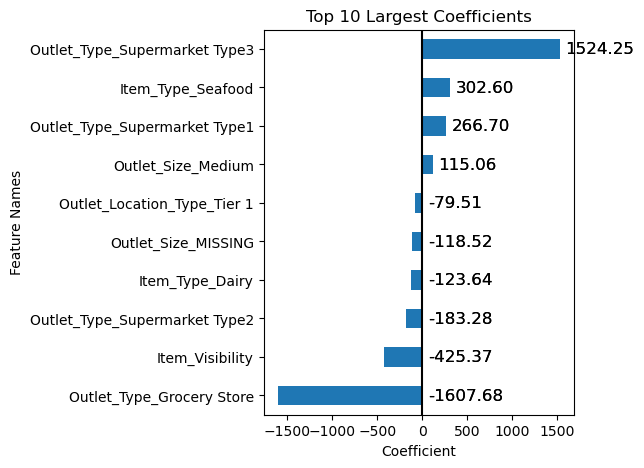

In [38]:
ax = plot_coeffs(coeffs,top_n=10,annotate=True);
annotate_hbars(ax)

## Top 3 Largest Coefficients

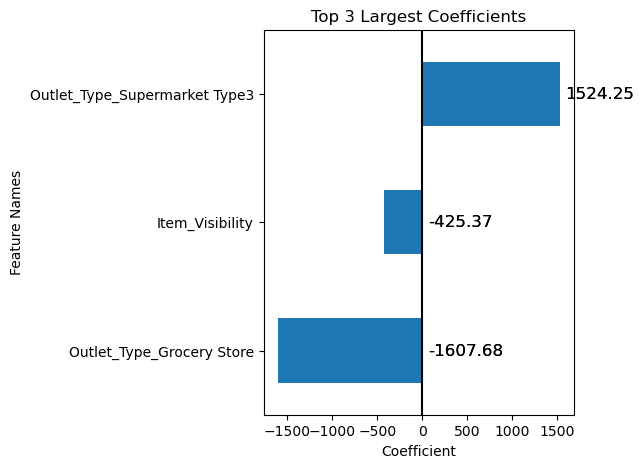

In [39]:
fig, ax = plt.subplots()
ax = plot_coeffs(coeffs,top_n=3,annotate=True);
annotate_hbars(ax)

## Select the top 3 most impactful features and interpret their coefficients in plain english.


1. Outlet_Type_Supermarket Type3:

  - This feature has a **positive** influence on the target (Item_Outlet_Sales) with a coefficient of 1524.25. 
  - Since this is a One-Hot-Encoded Categorical feature, it means that if the item belongs to this category, the Item_Outlet_Sales will be **increased** by **1524.25** rupees. 
  

2. Item_Visibility:
    
 - This feature has a **negative** influence on the target (Item_Outlet_Sales) with a coefficient of -425.37.  
 - Since this is a scaled numeric feature, it means that when I increase the value for this feature by 1 standard deviation, the Item_Outlet_Sales will be **decreased** by **425.37** rupees.


3. Outlet_Type_Grocery Store:

 - This feature has a **negative** influence on the target (Item_Outlet_Sales) with a coefficient of -1607.68.
 - Since this is a One-Hot-Encoded Categorical feature, it means that if the item belongs to this category, the Item_Outlet_Sales will be **decreased** by **1607.68** rupees.

## Save Figure as .PNG

In [40]:
import os
os.makedirs("images/", exist_ok=True)

In [41]:
fig.savefig('images/linear_regression_top3_coefficients.png')

# **Random Forest Model**

## Default Parameters

In [42]:
#Instantiate Model (default parameters) and Fit
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train_df,y_train)

RandomForestRegressor(random_state=42)

In [43]:
#Evaluate model with regression metrics
evaluate_regression(rf_reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 431.95
Test Data:	R^2= 0.55	RMSE= 1116.52


In [44]:
#Extract Feature Importances
rf_reg.feature_importances_

array([0.05251996, 0.10344788, 0.44717026, 0.00507703, 0.00515391,
       0.00409504, 0.00249088, 0.00267319, 0.00439933, 0.00602576,
       0.00571794, 0.00808848, 0.00303663, 0.00396491, 0.0064734 ,
       0.00349321, 0.00159165, 0.00170405, 0.00823204, 0.00535945,
       0.00343733, 0.00475957, 0.00607471, 0.00531671, 0.00800186,
       0.00624193, 0.0060452 , 0.00409272, 0.19172982, 0.00305989,
       0.00286243, 0.07766281])

In [45]:
## Save the feature importances as a Pandas Series
importances = pd.Series(rf_reg.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances

Item_Weight                       0.05
Item_Visibility                   0.10
Item_MRP                          0.45
Item_Fat_Content_Low Fat          0.01
Item_Fat_Content_Regular          0.01
Item_Type_Baking Goods            0.00
Item_Type_Breads                  0.00
Item_Type_Breakfast               0.00
Item_Type_Canned                  0.00
Item_Type_Dairy                   0.01
Item_Type_Frozen Foods            0.01
Item_Type_Fruits and Vegetables   0.01
Item_Type_Hard Drinks             0.00
Item_Type_Health and Hygiene      0.00
Item_Type_Household               0.01
Item_Type_Meat                    0.00
Item_Type_Others                  0.00
Item_Type_Seafood                 0.00
Item_Type_Snack Foods             0.01
Item_Type_Soft Drinks             0.01
Item_Type_Starchy Foods           0.00
Outlet_Size_High                  0.00
Outlet_Size_MISSING               0.01
Outlet_Size_Medium                0.01
Outlet_Size_Small                 0.01
Outlet_Location_Type_Tier

In [46]:
## Saving the feature importances sorted from smallest to largest (ascending=True)
sorted_importance = importances.sort_values()
sorted_importance

Item_Type_Others                  0.00
Item_Type_Seafood                 0.00
Item_Type_Breads                  0.00
Item_Type_Breakfast               0.00
Outlet_Type_Supermarket Type2     0.00
Item_Type_Hard Drinks             0.00
Outlet_Type_Supermarket Type1     0.00
Item_Type_Starchy Foods           0.00
Item_Type_Meat                    0.00
Item_Type_Health and Hygiene      0.00
Outlet_Location_Type_Tier 3       0.00
Item_Type_Baking Goods            0.00
Item_Type_Canned                  0.00
Outlet_Size_High                  0.00
Item_Fat_Content_Low Fat          0.01
Item_Fat_Content_Regular          0.01
Outlet_Size_Medium                0.01
Item_Type_Soft Drinks             0.01
Item_Type_Frozen Foods            0.01
Item_Type_Dairy                   0.01
Outlet_Location_Type_Tier 2       0.01
Outlet_Size_MISSING               0.01
Outlet_Location_Type_Tier 1       0.01
Item_Type_Household               0.01
Outlet_Size_Small                 0.01
Item_Type_Fruits and Vege

### Top 5 Most Important Features

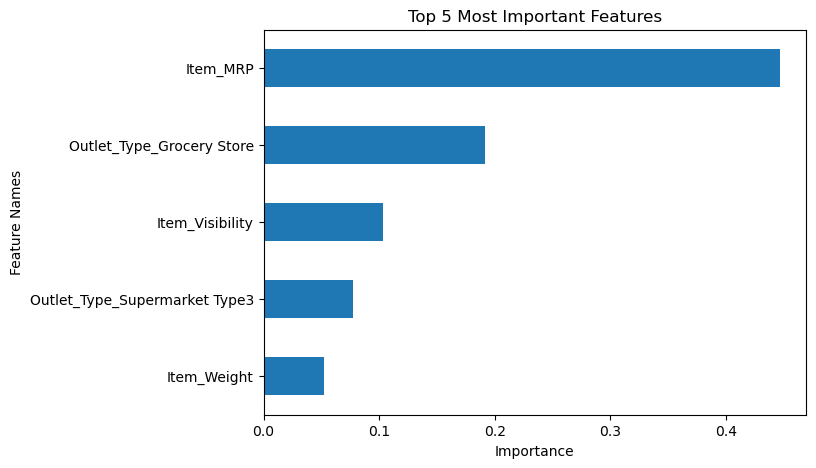

In [47]:
## plot top 5 importances
fig, ax = plt.subplots()
ax = sorted_importance.tail(5).plot(kind='barh',
                                    figsize=(7,5),
                                      )
ax.set(xlabel='Importance',
        ylabel='Feature Names',
        title='Top 5 Most Important Features');

### Identify the top 5 most important features.

The top 5 most important features are:
    
    - Item_MRP
    - Outlet_Type_Grocery Store
    - Item_Visibility
    - Outlet_Type_Supermarket Type3
    - Item_Weight

### Save Figure as .PNG

In [48]:
fig.savefig('images/default_random_forest_top5_important_features.png')

## Tuned Model

Using the optimized random forest model that was tuned previously.

In [49]:
#Instantiate Model (tuned) and Fit
optimized_rf = RandomForestRegressor(max_depth=5, n_estimators=150, random_state=42)
optimized_rf.fit(X_train_df,y_train)

RandomForestRegressor(max_depth=5, n_estimators=150, random_state=42)

In [50]:
#Evaluate model with regression metrics
evaluate_regression(optimized_rf, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.61	RMSE= 1073.83
Test Data:	R^2= 0.60	RMSE= 1046.59


In [51]:
#Extract Feature Importances
optimized_rf.feature_importances_

array([2.00354024e-04, 2.14652161e-03, 5.52896283e-01, 3.58414627e-05,
       2.12428807e-05, 3.39201759e-05, 1.65724254e-05, 4.33276170e-05,
       3.61349619e-05, 6.73288254e-05, 8.79669204e-05, 2.21324005e-04,
       9.25799749e-05, 1.32079244e-04, 1.22598636e-04, 7.51394327e-05,
       1.93255042e-06, 1.36010446e-05, 7.71662866e-05, 1.42602564e-04,
       9.58552085e-05, 6.68215236e-05, 3.38455138e-06, 0.00000000e+00,
       2.42982032e-06, 4.08649152e-06, 0.00000000e+00, 2.07169291e-06,
       3.15027059e-01, 6.57544777e-04, 4.98193161e-04, 1.27178036e-01])

In [52]:
## Save the feature importances as a Pandas Series
importances = pd.Series(optimized_rf.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances

Item_Weight                       0.00
Item_Visibility                   0.00
Item_MRP                          0.55
Item_Fat_Content_Low Fat          0.00
Item_Fat_Content_Regular          0.00
Item_Type_Baking Goods            0.00
Item_Type_Breads                  0.00
Item_Type_Breakfast               0.00
Item_Type_Canned                  0.00
Item_Type_Dairy                   0.00
Item_Type_Frozen Foods            0.00
Item_Type_Fruits and Vegetables   0.00
Item_Type_Hard Drinks             0.00
Item_Type_Health and Hygiene      0.00
Item_Type_Household               0.00
Item_Type_Meat                    0.00
Item_Type_Others                  0.00
Item_Type_Seafood                 0.00
Item_Type_Snack Foods             0.00
Item_Type_Soft Drinks             0.00
Item_Type_Starchy Foods           0.00
Outlet_Size_High                  0.00
Outlet_Size_MISSING               0.00
Outlet_Size_Medium                0.00
Outlet_Size_Small                 0.00
Outlet_Location_Type_Tier

In [53]:
## Saving the feature importances sorted from smallest to largest (ascending=True)
sorted_importance = importances.sort_values()
sorted_importance

Outlet_Size_Medium                0.00
Outlet_Location_Type_Tier 2       0.00
Item_Type_Others                  0.00
Outlet_Location_Type_Tier 3       0.00
Outlet_Size_Small                 0.00
Outlet_Size_MISSING               0.00
Outlet_Location_Type_Tier 1       0.00
Item_Type_Seafood                 0.00
Item_Type_Breads                  0.00
Item_Fat_Content_Regular          0.00
Item_Type_Baking Goods            0.00
Item_Fat_Content_Low Fat          0.00
Item_Type_Canned                  0.00
Item_Type_Breakfast               0.00
Outlet_Size_High                  0.00
Item_Type_Dairy                   0.00
Item_Type_Meat                    0.00
Item_Type_Snack Foods             0.00
Item_Type_Frozen Foods            0.00
Item_Type_Hard Drinks             0.00
Item_Type_Starchy Foods           0.00
Item_Type_Household               0.00
Item_Type_Health and Hygiene      0.00
Item_Type_Soft Drinks             0.00
Item_Weight                       0.00
Item_Type_Fruits and Vege

### Top 5 Most Important Features

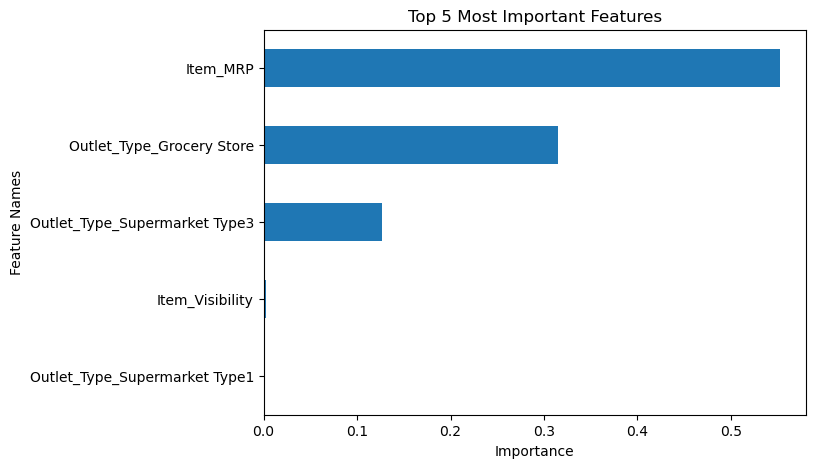

In [54]:
## plot top 5 importances
fig, ax = plt.subplots()
ax = sorted_importance.tail(5).plot(kind='barh',
                                    figsize=(7,5),
                                      )
ax.set(xlabel='Importance',
        ylabel='Feature Names',
        title='Top 5 Most Important Features');

### Identify the top 5 most important features

The top 5 most important features are:
    
    - Item_MRP
    - Outlet_Type_Grocery Store
    - Outlet_Type_Supermarket Type3
    - Item_Visibility
    - Outlet_Type_Supermarket Type1

### Save Figure as .PNG

In [55]:
fig.savefig('images/tuned_random_forest_top5_important_features.png')

# **Serialize Best Models with Joblib**


In [56]:
## saving variables
import joblib
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
         'y_test': y_test,
         'preprocessor':preprocessor,
         'LinearRegression': lin_reg,
         'RandomForest': optimized_rf}
joblib.dump(export, 'regression_models.joblib')

['regression_models.joblib']